# Boosted Decision Tree (BDT) for $H \rightarrow \rho\gamma, \phi\gamma$ Analysis

In [159]:
# General
import os, sys, json
# Handling ROOT files
import numpy as np, pandas as pd
import uproot, pickle
# Plotting
import matplotlib
from matplottery import Hist1D, Hist2D, plot_stack
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# Machine Learning
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import xgboost as xgb #BDT
# Custom Tools
from data import GetData, WriteJSON, JSONtoC
from config import config
# Jupyter Display Settings
%matplotlib inline
pd.set_option('display.max_rows', 20)

## Get Data

In [160]:
# Get dataframes
dfs_2016 = GetData("/nfs-7/userdata/jguiang/rare-higgs/2016/v3-0-0/", pklJar="pickles/2016", verbose=False)
dfs_2017 = GetData("/nfs-7/userdata/jguiang/rare-higgs/2017/v3-0-0/", pklJar="pickles/2017", verbose=False)
dfs_2018 = GetData("/nfs-7/userdata/jguiang/rare-higgs/2018/v3-0-0/", pklJar="pickles/2018", verbose=False)

In [161]:
# Concatenate dataframes
data = pd.concat(dfs_2016.values()+dfs_2017.values()+dfs_2018.values()).reset_index()
# Add bookkeeping columns
data["stype"] = data.name.astype('category').cat.codes
stypes = dict(set(zip(data["name"].values, data["stype"].values))) # Dictionary for easy reference
data["signal"] = data.name.str.contains(config["signal"])
# Drop phi or rho events, cut on mass
if config["analysis"] == "phi":
    data = data[(data.genKp_pt >= 0) | (~data.signal)]
    data = data[(data.recoPhi_mass > 1.0) & (data.recoPhi_mass < 1.04)]
elif config["analysis"] == "rho":
    data = data[(np.abs(data.genHiggsMeson_id) != 113 ) | (~data.signal)]

## Get Features for Training

In [162]:
# Get list of branch names
branches = data.columns
# Print branch names
print("Branch Names:\n"+", ".join(branches))

Branch Names:
entry, run, lumi, event, scale1fb, isGold, isHEM, met_pt, met_phi, rawMet_pt, rawMet_phi, HLT_singleMu, HLT_singleEl, passFilters, genRecoGamma_dR, genRecoPhi_dR, genRecoRho_dR, recoMagAng_cosThetaStar, recoMagAng_cosTheta1, recoMagAng_cosTheta2, recoMagAng_Phi, recoMagAng_Phi1, recoMagAng_m1, recoMagAng_m2, genW_pt, genW_eta, genW_phi, genW_mass, genWLepton_id, genWLepton_pt, genWLepton_eta, genWLepton_phi, genHiggs_pt, genHiggs_eta, genHiggs_phi, genHiggs_mass, genHiggsMeson_id, genHiggsMeson_pt, genHiggsMeson_eta, genHiggsMeson_phi, genHiggsMeson_mass, genHiggsMesonGamma_dR, genKm_pt, genKm_phi, genKm_eta, genKp_pt, genKp_phi, genKp_eta, genKpKm_dR, genGamma_pt, genGamma_phi, genGamma_eta, recoHiggs_mass, recoMeson_nCands, recoPhi_mass, recoPhi_pt, recoPhi_eta, recoPhi_phi, recoPhi_relIso, recoPhiGamma_dR, recoKm_pt, recoKm_eta, recoKm_phi, recoKm_relIso, recoKp_pt, recoKp_eta, recoKp_phi, recoKp_relIso, recoKpKm_dR, recoRho_mass, recoRho_pt, recoRho_eta, recoRho_phi, 

In [163]:
# Get bookkeeping columns to exclude in training
excludes = ["signal", "stype", "run", "lumi", "event", "scale1fb", "name", "recoMeson_nCands",
            "recoWLepton_nLep", "minGammaParton_dR", "recoWLepton_id", "isHEM", "isGold",
            "HLT_singleEl", "HLT_singleMu", "passFilters", "recoMagAng_m1", "recoMagAng_m2",
            "entry", "recoKp_relIso", "recoKm_relIso"]
# Add patterned excluded branch names to excludes
for bname in branches:
    if "gen" in bname: excludes.append(bname)
    elif "raw" in bname: excludes.append(bname)
    elif "Higgs" in bname: excludes.append(bname)
    if config["analysis"] == "phi":
        if "Rho" in bname: excludes.append(bname)
        elif "Pip" in bname: excludes.append(bname)
        elif "Pim" in bname: excludes.append(bname)
    if config["analysis"] == "rho":
        if "Phi" in bname: excludes.append(bname)
        elif "Kp" in bname: excludes.append(bname)
        elif "Km" in bname: excludes.append(bname)

# Collect selected features
features = sorted(list(set(data.columns.values)-set(excludes)))

In [164]:
# Display selected features
print("{0} Selected Features:\n{1}\n".format(len(features), ", ".join(features)))
# Display excluded features
print("{0} Excluded Features:\n{1}\n".format(len(excludes), ", ".join(excludes)))

28 Selected Features:
met_phi, met_pt, recoGammaWLepton_dR, recoGamma_eta, recoGamma_phi, recoGamma_pt, recoGamma_relIso, recoKm_eta, recoKm_phi, recoKm_pt, recoKpKm_dR, recoKp_eta, recoKp_phi, recoKp_pt, recoMagAng_Phi, recoMagAng_Phi1, recoMagAng_cosTheta1, recoMagAng_cosTheta2, recoMagAng_cosThetaStar, recoPhiGamma_dR, recoPhi_eta, recoPhi_mass, recoPhi_phi, recoPhi_pt, recoPhi_relIso, recoWLepton_eta, recoWLepton_phi, recoWLepton_pt

72 Excluded Features:
signal, stype, run, lumi, event, scale1fb, name, recoMeson_nCands, recoWLepton_nLep, minGammaParton_dR, recoWLepton_id, isHEM, isGold, HLT_singleEl, HLT_singleMu, passFilters, recoMagAng_m1, recoMagAng_m2, entry, recoKp_relIso, recoKm_relIso, rawMet_pt, rawMet_phi, genRecoGamma_dR, genRecoPhi_dR, genRecoRho_dR, genRecoRho_dR, genW_pt, genW_eta, genW_phi, genW_mass, genWLepton_id, genWLepton_pt, genWLepton_eta, genWLepton_phi, genHiggs_pt, genHiggs_eta, genHiggs_phi, genHiggs_mass, genHiggsMeson_id, genHiggsMeson_pt, genHiggsMeson_

In [165]:
# Weigh *_pt columns by reco Higgs mass
cols = list(set(data.columns[data.columns.str.contains("_pt")])-set(["recoWLepton_pt", "met_pt"]))
data[cols] = data[cols].div(data.recoHiggs_mass, axis=0)

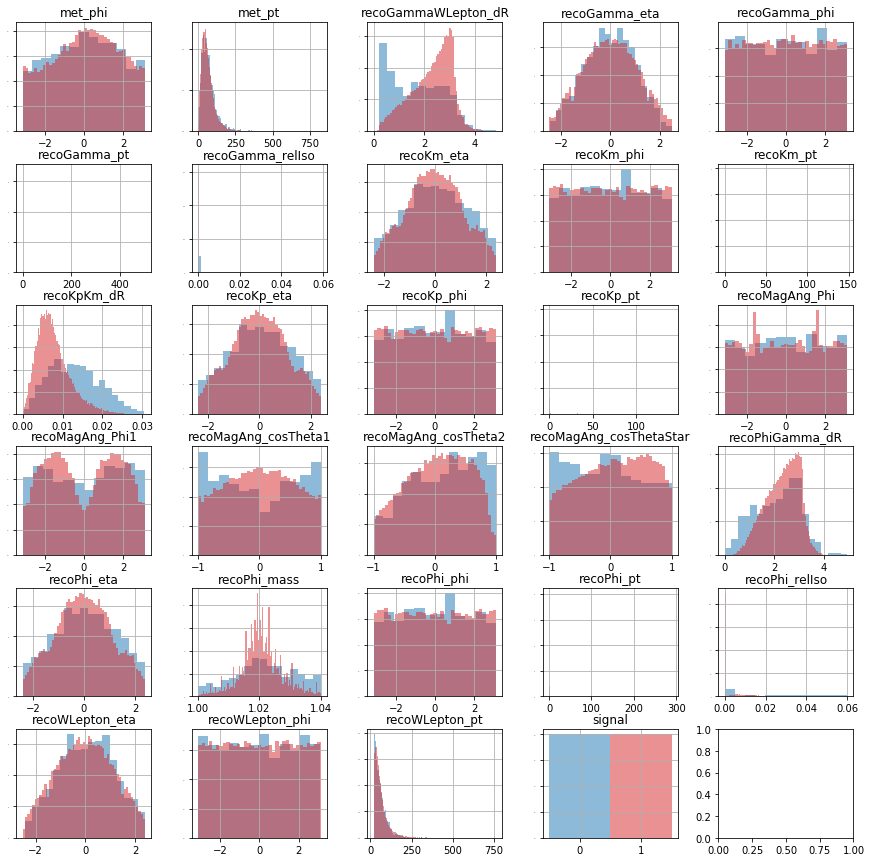

In [166]:
# Plot all columns separately for background and signal
fig, axes = plt.subplots(6,5,figsize=(15,15))
stypeSel = ((data.stype == stypes[config["signal"]]) | (data.stype == stypes["ttg_tbar2018"]))
isoSel = ((data.recoPhi_relIso < 1) & (data.recoGamma_relIso < 1) & (data.recoKp_relIso < 1) & (data.recoKm_relIso < 1))
toPlot = data[features+["signal"]][stypeSel & isoSel]
ax = toPlot[(toPlot.signal==0)].hist(ax=axes.flatten()[:len(toPlot.keys())],alpha=0.5,color="C0",ylabelsize=0,density=True,layout=(5,5),bins="auto")
ax = toPlot[(toPlot.signal==1)].hist(ax=axes.flatten()[:len(toPlot.keys())],alpha=0.5,color="C3",ylabelsize=0,density=True,layout=(5,5),bins="auto")

## Train BDT

In [167]:
# Split dataframe for training and testing
dummyWeights = np.ones(len(data["signal"])) # in place of data["weights"]
x_train, x_test, y_train, y_test, stype_train, stype_test, weights_train, weights_test = train_test_split(
                data,
                data["signal"],
                data["stype"],
                dummyWeights,
                test_size=0.25, random_state=42,
                )

In [168]:
# BDT Input
dtrain = xgb.DMatrix( x_train[features], label=y_train, weight=np.abs(weights_train))
dtest = xgb.DMatrix( x_test[features], label=y_test, weight=np.abs(weights_test))
evallist  = [(dtrain,'train'), (dtest,'eval')]

# BDT Parameters Setup
param = {}
param['objective'] = 'binary:logistic'

# BDT Knobs (Parameters)
num_round = 200                 # Number of training rounds
param['eta'] = 0.1              # Step size shrinkage (alias: learning_rate)
param['max_depth'] = 3          # Max. depth of tree: larger = more complex = more prone to overfitting
param['verbosity'] = 1          # 0 (silent), 1 (warning), 2 (info), 3 (debug)
param['nthread'] = 12           # Number of parallel threads
param['eval_metric'] = "auc"    # Evaluation metrics for validation data. 'auc' = Area Under the Curve
param['subsample'] = 0.6        # Subsample ratio of the training instances
param['alpha'] = 8.0            # L1 regularization term on weights: Larger = more conservative
param['gamma'] = 2.0            # Min. loss rediction to make leaf (alias: min_split_loss)
param['lambda'] = 1.0           # L2 regularization term on weights: Larger = more conservative
param['min_child_weight'] = 1.0 # Minimum sum of instance weight (hessian) needed in a child
param['colsample_bytree'] = 1.0 # The subsample ratio of columns when constructing each tree

In [169]:
# Get pos/neg weights
sumw_pos = np.abs(dtrain.get_weight()[dtrain.get_label()==1]).sum()
sumw_neg = np.abs(dtrain.get_weight()[dtrain.get_label()==0]).sum()
param["scale_pos_weight"] = sumw_neg/sumw_pos

In [170]:
# Train
bst = xgb.train( param.items(), dtrain, num_round, evallist, early_stopping_rounds=15, verbose_eval=False )

## Evaluate Performance

In [171]:
# Get predictions
preds_train = bst.predict(xgb.DMatrix(x_train[features]))
preds_test = bst.predict(xgb.DMatrix(x_test[features]))

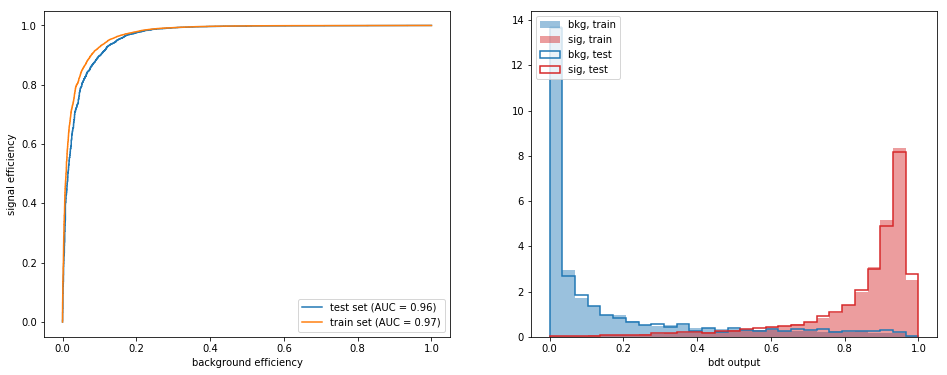

In [172]:
# Suplots setup
fig, axes = plt.subplots(1,2,figsize=(16,6))

# Subplot 1: Plot ROC curves
plt.subplot(1, 2, 1)
# Test ROC Curve
fpr, tpr, thresh = roc_curve(y_test,preds_test)
plt.plot(fpr, tpr, label="test set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));
# Train ROC Curve
fpr, tpr, thresh = roc_curve(y_train,preds_train)
plt.plot(fpr, tpr, label="train set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));
# Settings
plt.xlabel("background efficiency");
plt.ylabel("signal efficiency");
plt.legend();

# Subplot 2: Plot distribution of BDT outputs
plt.subplot(1, 2, 2)
bins = np.linspace(0.,1.,30)
# Training - Background
plt.hist(preds_train[y_train==0], weights=weights_train[y_train==0], bins=bins,histtype="stepfilled",alpha=0.45, density=True, label="bkg, train",color="C0");
# Training - Signal
plt.hist(preds_train[y_train==1], weights=weights_train[y_train==1], bins=bins,histtype="stepfilled",alpha=0.45, density=True, label="sig, train",color="C3");
# Testing - Background
plt.hist(preds_test[y_test==0], weights=weights_test[y_test==0], bins=bins,histtype="step",alpha=1.0, density=True, label="bkg, test",color="C0", lw=1.5, linestyle="solid");
# Testing - Signal
plt.hist(preds_test[y_test==1], weights=weights_test[y_test==1], bins=bins,histtype="step",alpha=1.0, density=True, label="sig, test",color="C3", lw=1.5, linestyle="solid");
# Settings
plt.xlabel("bdt output");
plt.legend(loc=2);

In [173]:
# Get cut scores
gainScore = pd.DataFrame(bst.get_score(importance_type='gain').items(), columns=['cut', 'gain'])
coverScore = pd.DataFrame(bst.get_score(importance_type='cover').items(), columns=['cut', 'cover'])
weightScore = pd.DataFrame(bst.get_score(importance_type='weight').items(), columns=['cut', 'weight'])
# Merge scores into single dataframe along 'cut' column
scores = reduce(lambda left,right: pd.merge(left,right,on='cut'), [gainScore, coverScore, weightScore])
# Display top ten cuts in 'gain'
scores.sort_values('gain', ascending=False)[:10]

,cut,gain,cover,weight
8,recoPhi_relIso,108.215134,996.636776,66
16,recoKpKm_dR,85.035345,675.767443,169
24,recoPhi_pt,76.409823,514.588819,115
20,recoGammaWLepton_dR,55.973616,864.714556,81
15,recoPhi_mass,38.675414,945.170314,79
6,recoKm_pt,21.849437,503.094462,54
7,recoPhiGamma_dR,21.304180,591.309759,97
21,recoKp_pt,20.113324,506.307475,65
1,recoGamma_relIso,14.217267,750.541336,34
4,recoMagAng_cosThetaStar,13.878457,527.349031,41


# Check for Higgs Mass Correlation

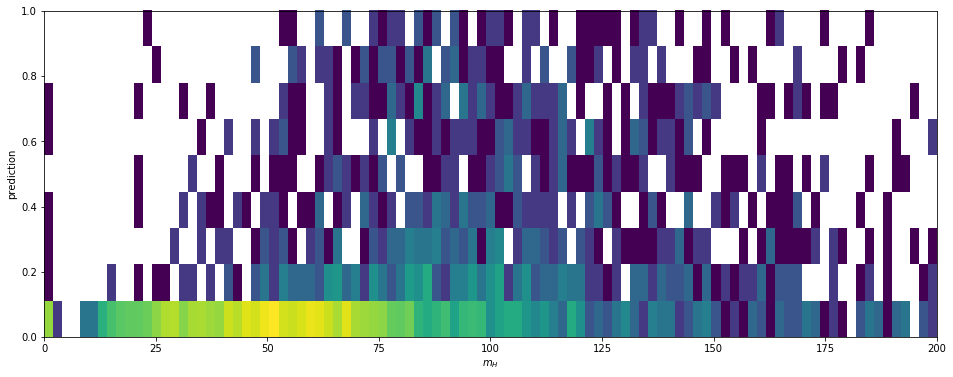

In [174]:
# Suplots setup
fig, axes = plt.subplots(1,1,figsize=(16,6))

# Subplot 1: Plot correlation btwn predictions and Higgs mass
plt.subplot(1, 1, 1)
# Correlation btwn predictions and Higgs mass
h2 = plt.hist2d(x_test["recoHiggs_mass"][x_test.signal == 0], preds_test[y_test == 0], norm=LogNorm(), bins=[np.linspace(0,200,100), np.linspace(0,1,10)]);
# Settings
plt.xlabel("$m_{H}$");
plt.ylabel("prediction");

# Check for Background Sculpting

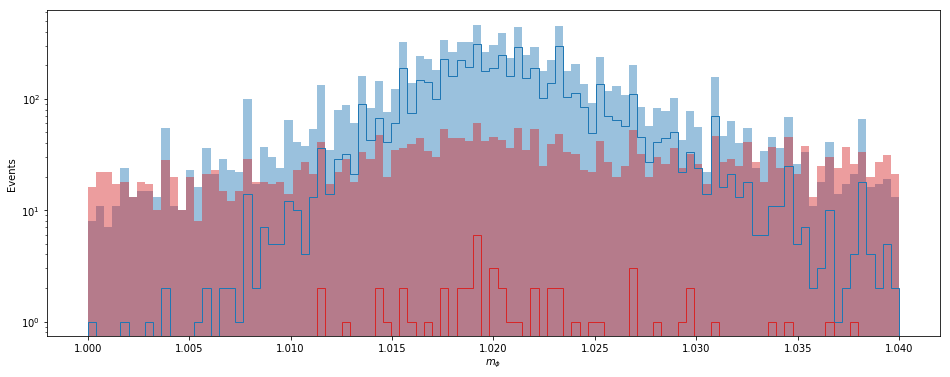

In [175]:
# Suplots setup
fig, axes = plt.subplots(1,1,figsize=(16,6))
bins = np.linspace(1,1.04,100)

# Subplot 1: Plot correlation btwn predictions and Higgs mass
plt.subplot(1, 1, 1)
# Correlation btwn predictions and Higgs mass
plt.hist(x_test["recoPhi_mass"][x_test.signal == 1], bins=bins, histtype="stepfilled",alpha=0.45, label="bkg, train",color="C0")
plt.hist(x_test["recoPhi_mass"][x_test.signal == 0], bins=bins, histtype="stepfilled",alpha=0.45, label="bkg, train",color="C3")
plt.hist(x_test["recoPhi_mass"][(preds_test > 0.9) & (x_test.signal == 1)], bins=bins, histtype="step",alpha=1.0, label="bkg, train",color="C0")
plt.hist(x_test["recoPhi_mass"][(preds_test > 0.9) & (x_test.signal == 0)], bins=bins, histtype="step",alpha=1.0, label="bkg, train",color="C3")
# # Settings
plt.yscale("log")
plt.xlabel("$m_{\phi}$");
plt.ylabel("Events");

## Save BDT

In [176]:
# Write BDT to JSON
WriteJSON("bdt.json", bst, features)
# Create C function that gives BDT predictions
JSONtoC("bdt.json", "bdt.h")
# Write BDT model and test data to pickle file
pickle.dump(bst, open("bdt.pkl", "w"))
x_test.to_pickle("x_test.pkl", compression="gzip")
# Write features to JSON
with open("features.json", "w") as fout:
    json.dump(features, fout)